In [3]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

%matplotlib inline

## Creating Data

Let's look at a cloud of data points surrounded by a circle. For this example, for each entry in the inner cloud is drawn from a $N(0,0.01)$, and each entry of the outer circle is sampled from a unit circle, with $N(0,0.01)$ noise added to each coordinate.

In [2]:
sampling_size = 100

sample = np.arange(sampling_size) * (np.pi/50)
outer_cloud = np.concatenate((np.expand_dims(np.cos(sample),1), 
                              np.expand_dims(np.sin(sample),1)), axis=1) + 0.1 * np.random.randn(sampling_size, 2)

inner_cloud = 0.1 * np.random.randn(sampling_size,2)

data = np.concatenate((outer_cloud, inner_cloud), axis=0)
colormap = np.concatenate((np.zeros(sampling_size),np.ones(sampling_size)))

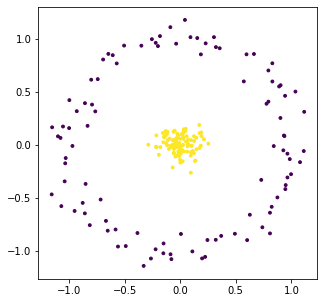

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(data[:,0], data[:,1], s=8, c=colormap);

### Some embeddings of this data

In [4]:
emb = np.empty((5, 2*sampling_size, 2))

In [5]:
emb[0] = KernelPCA(n_components=2, kernel='linear').fit_transform(data)
emb[1] = KernelPCA(n_components=2, kernel='poly').fit_transform(data)
emb[2] = KernelPCA(n_components=2, kernel='rbf').fit_transform(data)
emb[3] = KernelPCA(n_components=2, kernel='sigmoid').fit_transform(data)
emb[4] = KernelPCA(n_components=2, kernel='cosine').fit_transform(data)

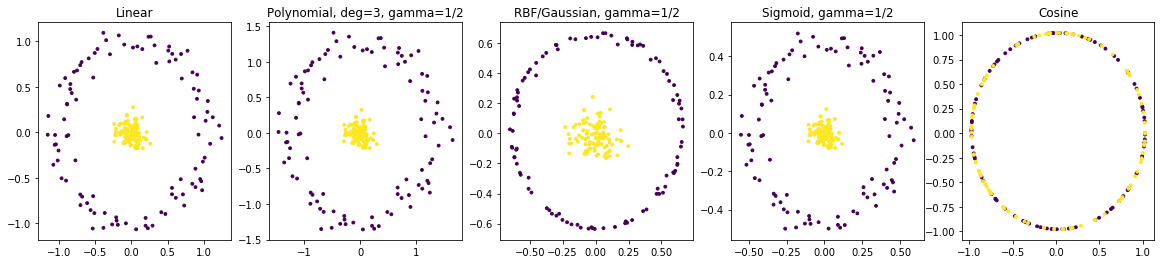

In [6]:
desc = ['Linear','Polynomial, deg=3, gamma=1/2', 'RBF/Gaussian, gamma=1/2', 'Sigmoid, gamma=1/2', 'Cosine']

fig,axes = plt.subplots(1,5, figsize=(20,4))
for i,ax in enumerate(axes.flat):
    ax.scatter(emb[i,:,0], emb[i,:,1], s=8, c=colormap)
    ax.set_title(desc[i])

### Varying Gamma for RBF (Gaussian) Kernel

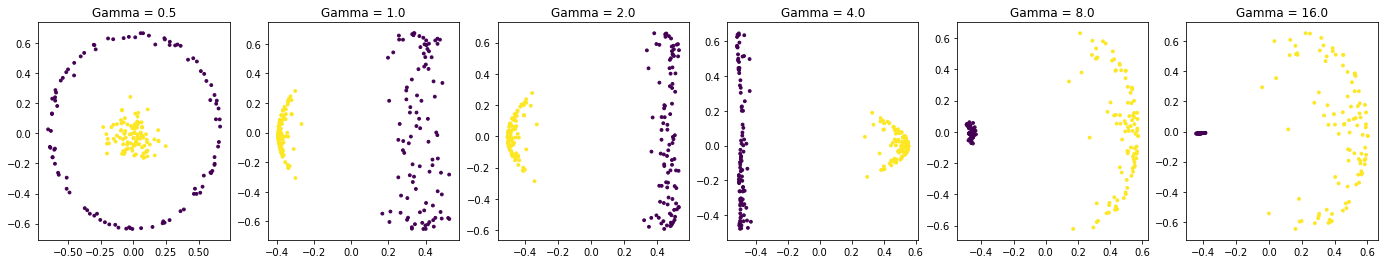

In [7]:
gamma_vals = np.asarray([0.5, 1, 2, 4, 8, 16])

emb = np.empty((gamma_vals.shape[0], 2*sampling_size, 2))

for i in range(gamma_vals.shape[0]):
    emb[i] = KernelPCA(n_components=2, kernel='rbf', gamma=gamma_vals[i]).fit_transform(data)

fig,axes = plt.subplots(1,gamma_vals.shape[0], figsize=(4*gamma_vals.shape[0],4))
for i,ax in enumerate(axes.flat):
    ax.scatter(emb[i,:,0], emb[i,:,1], s=8, c=colormap)
    ax.set_title(f"Gamma = {gamma_vals[i]}")

# Randomized KPCA

We can add randomness into Kernel PCA in two main ways:

- Using randomness to lower the dimensionality of the data matrix, similarly to RSVD
- Using randomness in the kernel function

First we attempt the second:

In [8]:
def RKPCA(data, n_components, m):
    X = np.copy(data) # n x d
    n, d = X.shape
    b = np.random.uniform(low=0, high = 2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=(2/784)*np.eye(d), size=m) # m x d
    Z = np.empty((n,m))
    Z = np.cos(X @ W.T + b) # n x m
    K = 1/m * Z @ Z.T
    return KernelPCA(n_components=n_components, kernel='precomputed').fit_transform(K)

In [9]:
def plot(embedding, color_labels):
    if(embedding.shape[1] == 2):
        plt.scatter(embedding[:,0],embedding[:,1],s=8,c=color_labels)
    elif(embedding.shape[1] == 3):
        ax = Axes3D(plt.figure())
        ax.scatter(embedding[:,0],embedding[:,1],embedding[:,2], s=8, c=color_labels)
    else:
        raise ValueError
    plt.show()

In [10]:
n, d = data.shape

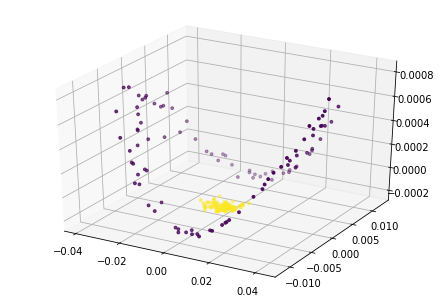

In [11]:
plot(RKPCA(data, 3, 10), colormap)

## Experiments on MNIST 

In [12]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

full_X = mnist[mnist.columns[1:]].values / 255
full_y = mnist.label.values

X = full_X[:1000]
y = full_y[:1000]

In [13]:
n,d = X.shape

### KPCA with polynomial kernel

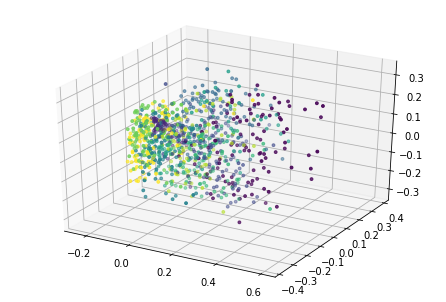

In [14]:
emb = KernelPCA(n_components=3, kernel='poly').fit_transform(X)
plot(emb, y)

### KPCA with gaussian kernel

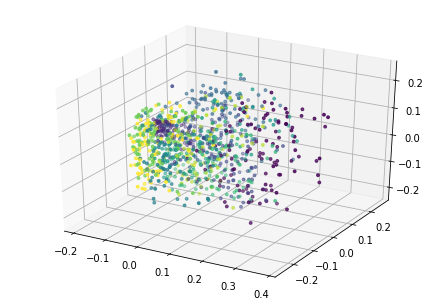

In [15]:
emb = KernelPCA(n_components=3, kernel='rbf').fit_transform(X)
plot(emb, y)

### RKPCA emulating gaussian kernel

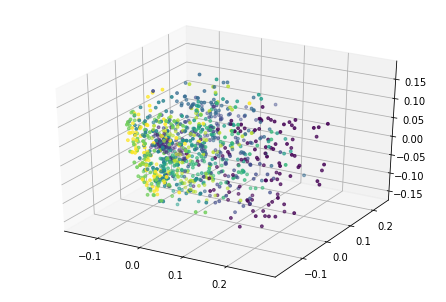

In [16]:
emb = RKPCA(X, 3, 600)
plot(emb, y)

In [17]:
#Reference
#from sklearn import manifold
#plot(manifold.TSNE(n_components=2).fit_transform(X), y)

# SVM Classification using Random Fourier Features Kernel

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [49]:
def generate_kernel(m=350, s=1/d):
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=2*s*np.eye(d), size=m) # m x d
    def ker(x, y):
        z1 = np.cos(x @ W.T + b)
        z2 = np.cos(y @ W.T + b)
        return z1 @ z2.T / m
    return ker

In [50]:
large_X = full_X[:10000]
large_y = full_y[:10000]
large_X_train, large_X_test, large_y_train, large_y_test = train_test_split(large_X, large_y, test_size=0.2, random_state=15)

In [51]:
start = perf_counter()
svm = SVC(gamma='auto')
svm.fit(large_X_train, large_y_train)
det_score = svm.score(large_X_test, large_y_test)
end = perf_counter()
det_time = end - start


iterations = 100
scores = np.empty(iterations)
times = np.empty(iterations)

for i in tqdm(range(iterations)):
    start = perf_counter()
    random_svm = SVC(kernel=generate_kernel())
    random_svm.fit(large_X_train, large_y_train)
    end = perf_counter()
    times[i] = end - start
    scores[i] = random_svm.score(large_X_test, large_y_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:53<00:00,  4.13s/it]


In [52]:
print(f'Gaussian kernel: Accuracy: {det_score}, time: {det_time}')
print(f'Random kernel: Mean accuracy: {np.mean(scores)}, stdev: {np.std(scores)}, mean time: {np.mean(times)}')
print(f'Acc. stats: Q0: {np.min(scores)}, Q1: {np.quantile(scores, 0.25)}, Q2: {np.median(scores)}, Q3: {np.quantile(scores,0.75)}, Q4: {np.max(scores)}')

Gaussian kernel: Accuracy: 0.9195, time: 56.80973240000003
Random kernel: Mean accuracy: 0.890115, stdev: 0.00408402681186106, mean time: 3.22111706300002
Acc. stats: Q0: 0.877, Q1: 0.8883749999999999, Q2: 0.8905, Q3: 0.8925, Q4: 0.902


## Accuracy as a function of gamma

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
domain = (1/784) * np.asarray([.125,.25,.5,1,2,4,8,16,32,64,128])

### deterministic rbf kernel

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.29s/it]


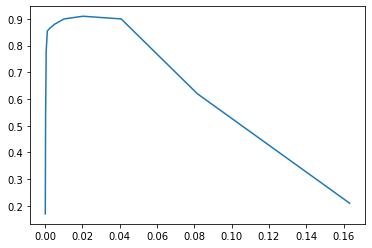

In [24]:
scores = []

for val in tqdm(domain):
    svm = SVC(gamma=val)
    svm.fit(X_train, y_train)
    scores.append(svm.score(X_test, y_test))
    
plt.plot(domain, scores)
plt.title('Deterministic Gaussian kernel SVM')

### random rbf kernel

In [42]:
iterations = 10
scores = np.empty((domain.shape[0], iterations))
    
for i,val in enumerate(domain):
    for j in range(iterations):
        random_svm = SVC(kernel=generate_kernel(s=val))
        random_svm.fit(X_train, y_train)
        scores[i,j] = random_svm.score(X_test, y_test)

stat = np.empty((7, domain.shape[0]))
stat[0] = np.min(scores, axis=1)
stat[1] = np.quantile(scores, 0.25, axis=1)
stat[2] = np.median(scores, axis=1)
stat[3] = np.quantile(scores, 0.75, axis=1)
stat[4] = np.max(scores, axis=1)
stat[5] = np.mean(scores, axis=1)
stat[6] = np.std(scores, axis=1)

Text(0.5, 1.0, "Randomized Kernel SVM accuracy 'continuous boxplot'")

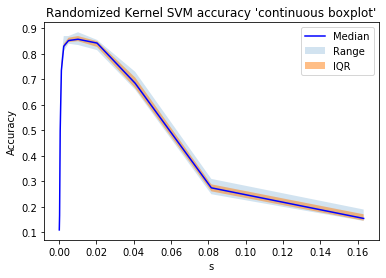

In [43]:
plt.plot(domain, stat[2], c='b', label='Median')
plt.fill_between(domain, stat[4], stat[0], alpha=0.2, label='Range', lw=1)
plt.fill_between(domain, stat[1], stat[3], alpha=0.5, label='IQR', lw=1)
plt.xlabel('s')
plt.ylabel('Accuracy')
#plt.set_yscale('log')
plt.legend(loc='upper right')
plt.title('Randomized Kernel SVM accuracy \'continuous boxplot\'')

In the randomized case, we sample $\mathbf{w}_i \sim N(0,2s\mathbf{I})$ to approximate a deterministic rbf kernel with parameter $\gamma$.

### accuracy as a function of m (low-dim projection dim)

In [46]:
m_domain = np.asarray([10, 50, 100, 200, 400, 750])
np.arange(start=100, stop=800, step=100)

array([100, 200, 300, 400, 500, 600, 700])

In [47]:
iterations = 10
scores = np.empty((m_domain.shape[0], iterations))
    
for i,val in enumerate(m_domain):
    for j in range(iterations):
        random_svm = SVC(kernel=generate_kernel(m=val))
        random_svm.fit(X_train, y_train)
        scores[i,j] = random_svm.score(X_test, y_test)
        
stat = np.empty((7, m_domain.shape[0]))
stat[0] = np.min(scores, axis=1)
stat[1] = np.quantile(scores, 0.25, axis=1)
stat[2] = np.median(scores, axis=1)
stat[3] = np.quantile(scores, 0.75, axis=1)
stat[4] = np.max(scores, axis=1)
stat[5] = np.mean(scores, axis=1)
stat[6] = np.std(scores, axis=1)

Text(0.5, 1.0, 'Randomized Kernel SVM accuracy as a function of m')

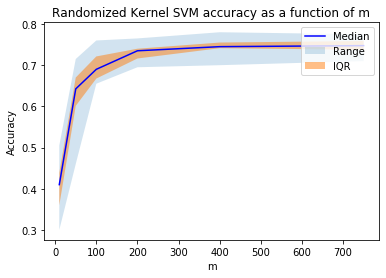

In [48]:
plt.plot(m_domain, stat[2], c='b', label='Median')
plt.fill_between(m_domain, stat[4], stat[0], alpha=0.2, label='Range', lw=1)
plt.fill_between(m_domain, stat[1], stat[3], alpha=0.5, label='IQR', lw=1)
plt.xlabel('m')
plt.ylabel('Accuracy')
#plt.set_yscale('log')
plt.legend(loc='upper right')
plt.title('Randomized Kernel SVM accuracy as a function of m')

## Plotting code for KPCA demonstration with slider widget

Often needs to be run twice to actually work, not sure why

In [30]:
# # TEST cell for plotting
# %matplotlib notebook
# from ipywidgets import *

# plt.ion()

# emb = KernelPCA(n_components=2, kernel='rbf', gamma=0.5).fit_transform(data)
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# outer, = ax.plot(emb.T[0][:100],emb.T[1][:100],marker='o', linestyle='', color='y')
# inner, = ax.plot(emb.T[0][100:200],emb.T[1][100:200],marker='o', linestyle='', color='purple')

# def update(gamma):
#     emb = KernelPCA(n_components=2, kernel='rbf', gamma=gamma).fit_transform(data)
#     outer.set_xdata(emb.T[0][:100])
#     outer.set_ydata(emb.T[1][:100])
#     inner.set_xdata(emb.T[0][100:200])
#     inner.set_ydata(emb.T[1][100:200])
    
#     fig.canvas.draw_idle()

# interact(update, gamma = widgets.FloatSlider(value=0.5,min=0,max=30,step=0.01))

# %matplotlib inline

### Code used to create GIF of RKPCA

In [31]:
# domain = np.square(np.arange(0.02,5,0.02))

# for i,value in enumerate(domain):
#     emb = KernelPCA(n_components=2, kernel='rbf', gamma=value).fit_transform(data)
#     plt.scatter(emb.T[0],emb.T[1], s=8, c=colormap)
#     plt.ylim(-0.7, 0.7)
#     plt.xlim(-0.7, 0.7)
#     plt.savefig('temp/img'+str(i).zfill(4)+'.png')
#     plt.clf()

## Principle Component Analysis

Principle component analysis (PCA) is a technique for _linear dimension reduction_. Since some measurements/features of data may tell us a lot about it, and other may not tell us as much, our goal is to find a smaller set of measurements that still capture most of the interesting information.

In PCA, our goal specifically is to calculate an orthogonal set of linear combinations of features that captures the most variance of the data.

Let's say we have $n$ points in $\mathbb{R}^d$, and we want to represent them as points in $\mathbb{R}^k$, with $k<d$. Write this dataset as a matrix $X\in\mathbb{R}^{n\times d}$, and then let $X_0$ represented the _centered_ version, obtained by subtracting the mean of each column from all the entries in that column. Then
$$D = \frac{1}{n}X_0^T X_0$$
is the covariance matrix of the data $X$. Note $D$ is a symmetric, $n\times n$, positive semi-definite matrix.

Saving the details, it turns out that the eigendecomposition $D = Q\Lambda Q^T$ solves our problem: the columns of $Q$ form an orthonormal basis for the span of the data, and they are ordered in terms of how much variability of the data they capture, with the order determined by the corresponding eigenvalues in $\Lambda$ (the spectral theorem guarentees that the eigenvalues will be real and nonnegative).

Here's an example illustrating what the principle components will be for a 2 dimensional set of data points:

![Example](../examples/kpca/pc.gif)

The red and green arrows represent the principle components, or eigenvectors found in $Q$. Note that they are orthogonal. While this two dimensional example is simplistic, it provides intuition for the case of higher dimensional data. 

## Kernel PCA

Not every dataset is linearly separable. For this reason, we introduce kernel methods. Kernel methods are class of methods used not only in PCA, but in other algorithms as well (SVM, coming later).

In order to solve the problem of lack of linear separability, we map the data into a higher dimensional space using a _kernel_, which is a type of function that satisfies certain properties. Examples of kernel functions include:

$$\text{Linear kernel: }\quad k(x,y) = x^Ty$$

$$\text{Gaussian (rbf) kernel: }\quad k(x,y) = \exp(-\gamma \|x-y\|_2^2)$$

For example, using a dataset from our last presentation:

![Example](../examples/kpca/fakedata.png)

Kernel PCA with a Gaussian kernel with $\gamma=2$. The _linear_ separability after application of a Gaussian kernel corresponds with a sort of ellipsoidal separability in the original data.

![Example](../examples/kpca/decision.png)

## Approximating the Kernel with Random Fourier Features

Calculating the kernel may be computationally expensive. There exist multiple ways to approximate it, but we talk about the method of random Fourier features (Rahimi & Recht, 2008). If our data points are in $\mathbb{R}^d$, assuming the kernel function has an inverse Fourier transform $p(w)$, we may express the kernel as 

$$k(x,y) = \int_{\mathbb{R}^d} p(w) e^{iw^T(x-y)}dw$$

and we may approximate this integral by a form of Monte Carlo:

$$\sum_{j=1}^m \frac{1}{m} \cos(w_i^Tx + b_i)\cos(w_i^Ty + b_i)$$

where $w_i\sim p(w)$, $b_i\sim \text{Uniform }(0,2\pi)$. $m$ is the amount of random Fourier features sampled to approximate the integral.

For example, to approximate a Gaussian kernel with parameter $\gamma$, we sample $w_i\sim N(0,2\gamma I)$. Here is an example of the output of PCA using this kernel on the same data:

![Example](../examples/kpca/rkpca.png)


In [34]:
from sklearn.decomposition import PCA

In [107]:

for i in range(dataovertime.shape[0]):

    w,v = np.linalg.eig((1/100)*dataovertime[i] @ dataovertime[i].T)

    origin = [0], [0]
    plt.quiver(*origin, v[0], v[1], color=['r','g'], scale=5)

    plt.scatter(dataovertime[i][0],dataovertime[i][1],s=8)
    plt.ylim(-8,8)
    plt.xlim(-8,8)
    plt.title('Principle Components Demonstration')
    plt.savefig('temp/img'+str(i).zfill(4)+'.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [106]:
v[0]

array([-0.74566755,  0.66631817])

In [21]:
rd = np.arange(4,0,-0.04)
rd
first = np.concatenate((rd,rd[::-1]))

In [22]:
first.shape

(200,)

In [23]:
tl = np.arange(-2.5,2.5,0.025)

In [24]:
tl.shape

(200,)

In [26]:
toprow = np.concatenate((np.expand_dims(first,axis=1), np.expand_dims(tl,axis=1)), axis=1)

In [29]:
botrow = np.concatenate((np.expand_dims(tl,axis=1), np.expand_dims(first,axis=1)), axis=1)

In [30]:
covar = np.concatenate((np.expand_dims(toprow, axis=2), np.expand_dims(botrow, axis=2)), axis=2)

In [73]:
data = np.random.multivariate_normal(mean=np.zeros(2), cov=covar[0], size=100)


In [80]:
thetas = np.arange(0,2*np.pi, 0.03)
thetas.shape[0]

210

In [84]:
dataovertime = np.empty((210,2,100))

for i,t in enumerate(thetas):
    rotm = np.asarray([[np.cos(t),-np.sin(t)],[np.sin(t),np.cos(t)]])
    dataovertime[i] = rotm @ data.T

In [86]:
dataovertime.shape

(210, 2, 100)

In [87]:
data.shape

(100, 2)

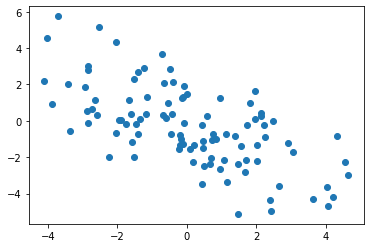

In [91]:
plt.scatter(dataovertime[0][0],dataovertime[0][1])